# SVC

In [38]:
from __future__      import division
from IPython.display import display
from matplotlib      import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os

from sklearn.svm              import SVC

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV

In [39]:
SEED   = 97

scale  = False 
minmax = False
norm   = False
nointercept = False
engineering = True

submission_filename = "../submissions/submission_SVC.csv"

# Load the training data

In [40]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Fit the model

In [41]:
%%time

random.seed(SEED)
 
clf = SVC(C                       = 1.0, 
          kernel                  = 'rbf', 
          degree                  = 3, 
          gamma                   = 'auto', 
          coef0                   = 0.0, 
          
          shrinking               = True, 
          probability             = True, 
          tol                     = 0.001, 
          cache_size              = 2000, 
          class_weight            = None, 
          verbose                 = False, 
          max_iter                = -1, 
          #decision_function_shape = None, 
          random_state            = SEED)




# param_grid = dict(gamma  = [0.00001, 0.0001, 0.001, 0.01, 0.1,'auto'],
#                   C      = [0.001, 0.01, 0.1, 1.0])

# StatifiedCV = StratifiedKFold(y            = y_train, 
#                               n_folds      = 10, 
#                               shuffle      = True, 
#                               random_state = SEED)

# grid_clf = GridSearchCV(estimator  = clf, 
#                         param_grid = param_grid,
#                         n_jobs     = -1,  
#                         cv         = StatifiedCV).fit(X_train, y_train)

# print("clf_params = {}".format(grid_clf.best_params_))
# print("score: {}".format(grid_clf.best_score_))

# clf = grid_clf.best_estimator_




# clf_params = {'C': 1.0, 'gamma': 0.0001}
# clf.set_params(**svc_params)
clf.fit(X_train, y_train)
print(clf.get_params())
print

{'kernel': 'rbf', 'C': 1.0, 'verbose': False, 'probability': True, 'degree': 3, 'shrinking': True, 'max_iter': -1, 'decision_function_shape': None, 'random_state': 97, 'tol': 0.001, 'cache_size': 2000, 'coef0': 0.0, 'gamma': 'auto', 'class_weight': None}

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 46.2 ms


In [42]:
# from sklearn_utilities import GridSearchHeatmap

# GridSearchHeatmap(grid_clf, y_key='C', x_key='gamma')

# from sklearn_utilities import plot_validation_curves

# plot_validation_curves(grid_clf, param_grid, X_train, y_train, ylim = (0.0, 1.05))

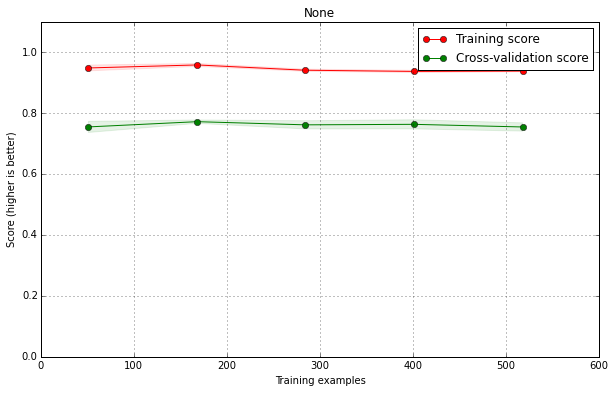

CPU times: user 208 ms, sys: 60 ms, total: 268 ms
Wall time: 817 ms


In [43]:
%%time

try:
    from sklearn_utilities import plot_learning_curve
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_learning_curve
    

plot_learning_curve(estimator   = clf, 
                    title       = None, 
                    X           = X_train, 
                    y           = y_train, 
                    ylim        = (0.0, 1.10), 
                    cv          = StratifiedKFold(y            = y_train, 
                                                  n_folds      = 10, 
                                                  shuffle      = True, 
                                                  random_state = SEED), 
                    train_sizes = np.linspace(.1, 1.0, 5),
                    n_jobs      = -1)

plt.show()

# Training set predictions

In [44]:
predicted_values = clf.predict(X_train)
y_true, y_pred   = y_train, predicted_values

predicted_probs  = clf.predict_proba(X_train)

[[436   2]
 [ 35 103]]


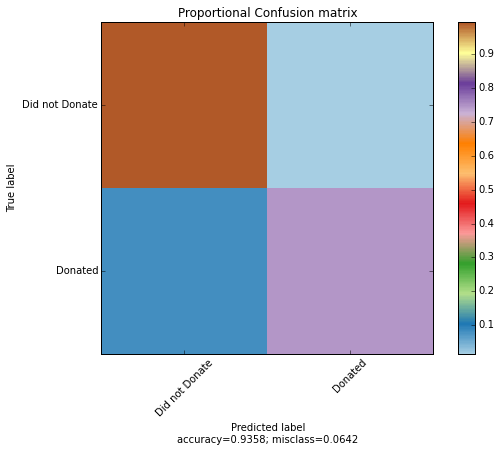

Accuracy 0.9358, mis-class rate 0.0642


In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix


plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy, misclass))

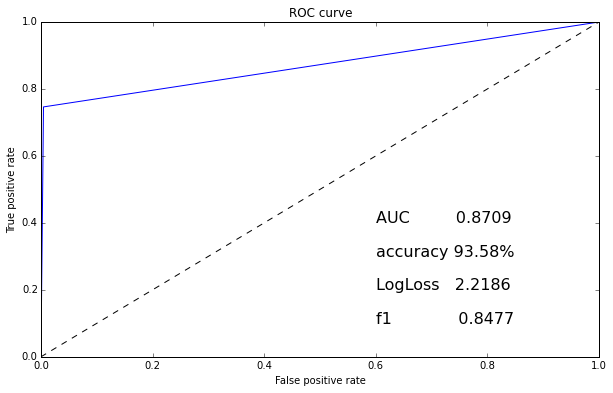

In [46]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(roc_auc_score(y_true, y_pred, average='macro')),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(log_loss(y_true, y_pred)),
        fontsize=16)

plt.text(x=0.6,y=0.1,s="f1             {:.4f}"\
         .format(f1_score(y_true, y_pred)),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

# ----------------------------------------------------------------------------------------

# Test Set Predictions

## Load the test data

In [10]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the fitted model

In [11]:
y_pred        = clf.predict(X_test)
y_pred_probs  = clf.predict_proba(X_test)
donate_probs  = [prob[1] for prob in y_pred_probs]

In [12]:
print(y_pred[:10])
print(y_pred_probs[:10])
print(donate_probs[:10])

[0 0 0 0 0 0 0 0 0 0]
[[ 0.75605893  0.24394107]
 [ 0.75605893  0.24394107]
 [ 0.79849068  0.20150932]
 [ 0.75605893  0.24394107]
 [ 0.75605893  0.24394107]
 [ 0.75605893  0.24394107]
 [ 0.79840143  0.20159857]
 [ 0.7984571   0.2015429 ]
 [ 0.75605893  0.24394107]
 [ 0.75605893  0.24394107]]
[0.24394106558424114, 0.24394106546378802, 0.20150931581576556, 0.24394106546378802, 0.24394106546378802, 0.24394106546378802, 0.20159856526942729, 0.20154289911104903, 0.24394106546378802, 0.24394106546378802]


# Create the submission file

In [13]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()